# Pytorch Model

In [1]:
import numpy as np
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")
from sklearn.metrics import accuracy_score

import torch

In [2]:
# D: Hilfsfunktion um die vorhergesagten Wahrscheinlichkeiten in die Klassen umzuwandeln
# ---------
# E: Auxiliary function to convert the predicted probabilities into the classes
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [3]:
# D: Hilfsfunktion um die Daten zu Visualisiern
# ---------
# E: Help function to visualize the data
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

In [4]:
# D: Hilfsfunktion Kosten und Genauigkeit zu visualisieren
# ---------
# E: Help function to visualize cost and accuracy
def plot_learn_data(data1,data2,name="Cost"):
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$Epochen$", ylabel=name)
    plt.title(name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    plt.plot(data1)
    plt.plot(data2)
    axes.legend(['Train Set', 'Test Set'])

In [5]:
# D: Größe des Datensatzes
# ---------
# E: Size of the dataset
N_SAMPLES = 1000
# D: Größe des Testsets
# ---------
# E: Size of the testset
TEST_SIZE = 0.1

In [6]:
# D: Generierung des Datansatzes und split in test und train set
# ---------
# E: generation of the data set and split into test and train set
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [7]:
# D: Check ob eine GPU da ist
# ---------
# E: Check if GPU is  available 
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

output = False

# D: Architektur des neuronalen Netzwerks
# wichtig ist, dass die aufeinander folgenden Layer die gleiche Größe haben
# ---------
# E: architecture of the neural network
# it is important that the successive layers have the same size
model = torch.nn.Sequential(
            torch.nn.Linear(2, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 1),
            torch.nn.Sigmoid()
)
# D: Festlegen der Lossfunktion
# ---------
# E: Determine the loss function
loss_fn = torch.nn.BCELoss()

# D: Alles rüberschieben, sodass pytorch alles übernimmt
# Pytorch will Tensoren haben
# ---------
# E: Move everything over so that pytorch takes over everything
# Pytorch wants to have tensors
xx = torch.from_numpy(X_train).to(device,torch.float32)
yy = torch.from_numpy(y_train).to(device,torch.float32)
yy = yy.unsqueeze(-1)

xx_test = torch.from_numpy(X_test).to(device,torch.float32)
yy_test = torch.from_numpy(y_test).to(device,torch.float32)
yy_test = yy_test.unsqueeze(-1)

cost_history = []
accuracy_history = []
cost_test_history = []
accuracy_test_history = [] 

# D: Festlegen der Lernrate 
# ---------
# E: Determine the learning rate
learning_rate = 1e-4
# D: Festlegen des Optimierungsalgorithmus
# ---------
# E: Determine the optimization algorithm
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# Schleife über eine Anzahl von vorher festgelegten Epochen, um zu lernen
# ---------
# Loop over a number of pre-determined epochs to learn
for t in range(10000):
    # D: Vorwärtsdurchlauf
    # ---------
    # E: Forward pass
    y_pred = model(xx)

    # D: Lossfunktion ausrechnen und anzeigen Trainings Set
    # ---------
    # E: Calculate and display loss function train set
    loss = loss_fn(y_pred, yy)
    cost_history.append(loss.detach().numpy())

    # D: Genauigkeit ausrechnen Training Set
    # ---------
    # E: Calculate accuracy train set
    y_classes = convert_prob_into_class(y_pred.detach().numpy())
    acc = (y_train.reshape(int(N_SAMPLES*(1-TEST_SIZE)),1) == y_classes).all(axis=1).mean()
    accuracy_history.append(acc)

    # D: Test Set
    # ---------
    # E: test set
    y_pred_test = model(xx_test)

    # D: Lossfunktion ausrechnen und anzeigen
    # ---------
    # E: Calculate and display loss function
    loss_test = loss_fn(y_pred_test, yy_test)
    cost_test_history.append(loss_test.detach().numpy())

    # D: Genauigkeit ausrechnen
    # ---------
    # E: Calculate accuracy test set
    y_classes_test = convert_prob_into_class(y_pred_test.detach().numpy())
    acc_test = (y_test.reshape(int(N_SAMPLES*TEST_SIZE),1) == y_classes_test).all(axis=1).mean()
    accuracy_test_history.append(acc_test)

    history = [cost_history, accuracy_history, cost_test_history, accuracy_test_history ]
    
    if t % 100 == 99 and output:
        print(t, loss.item())

    # D: Pytorch buffert den Gradienten aus allen vorigen Berechnungen
    # Um das los zu werden und nur den aktuellen zu haben
    # Nullen wir einmal den Gradienten
    # ---------
    # E: Pytorch buffers the gradient from all previous calculations.
    # To get rid of this and have only the current one
    # Let's zero the gradient once
    optimizer.zero_grad()

    # D: Rückwärtsdurchlauf
    # ---------
    # E: Backward pass
    loss.backward()

    # D: Update der Parameter
    # ---------
    # E: update parameter
    optimizer.step()

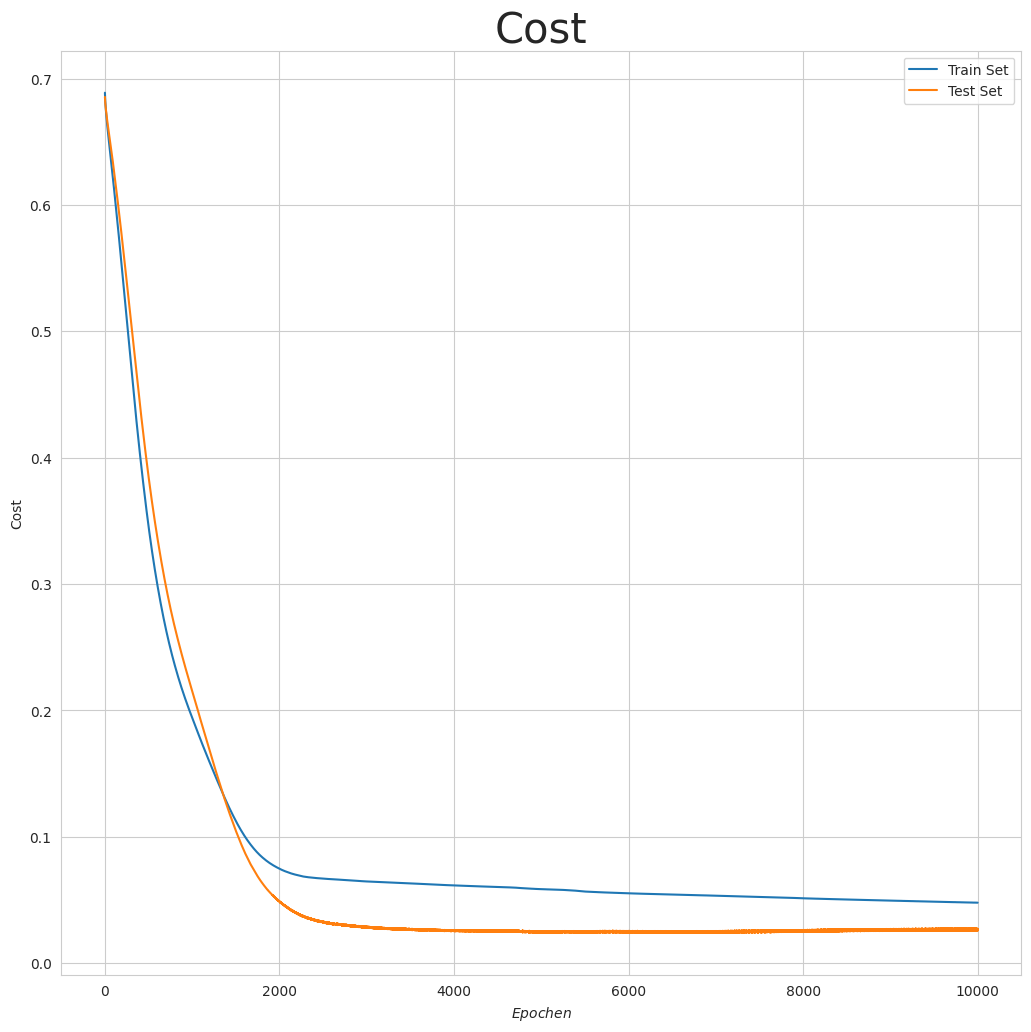

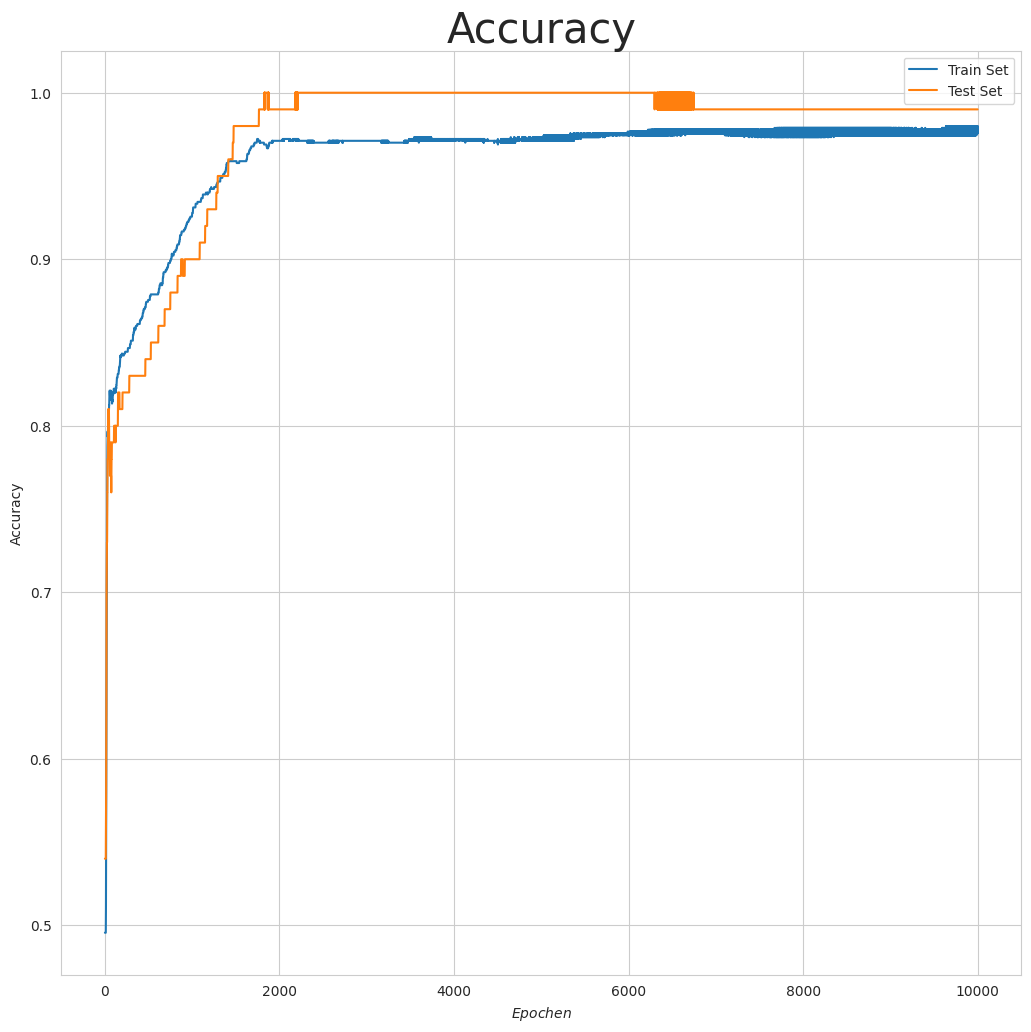

In [8]:
# D: Plot der Kostenfunktion
# ---------
# E: Plot of the cost function
plot_learn_data(history[0],history[2])
# D: Plot Genauigkeit
# ---------
# E: Plot of the accuracy
plot_learn_data(history[1],history[3],name="Accuracy")

In [9]:
# D: Hilfsvariablen für die Visualisierung
# ---------
# E: Auxiliary variables for visualization
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2

# D: Erstellen eines Gitter für das Bild
# ---------
# E: Create a grid for the image
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

In [10]:
# D: Testset zu pytorch schrieben
# ---------
# E: convert test set to tensor for pytorch
xx_test = torch.from_numpy(X_test).to(device,torch.float32)
# D: Vorwärtsdurchlauf auf dem Testset
# ---------
# E: Forward pass on the test set
y_hat = model(xx_test).cpu().detach().numpy()
# D: Umwandeln in Klassen
# ---------
# E: Convert to classes
y_pred = convert_prob_into_class(y_hat)
acc_test = (y_test.reshape(int(N_SAMPLES*TEST_SIZE),1) == y_pred).all(axis=1).mean()
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 0.99


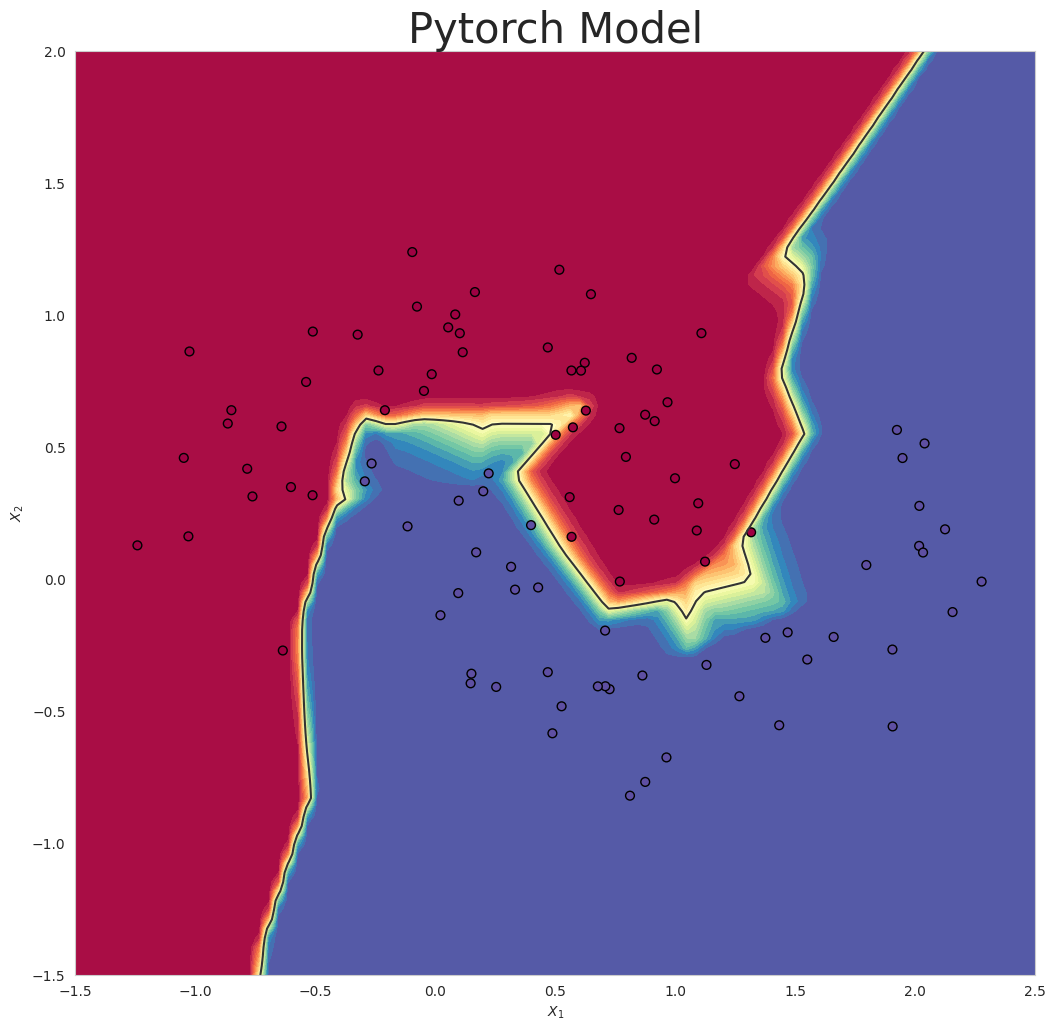

In [11]:
# D: Visualisierung der gelernten Gewichte und dem Test set
# ---------
# E: Visualization of the learned weights and the test set
xx = torch.from_numpy(grid_2d).to(device,torch.float32)
y_plot = y_hat = model(xx).cpu().detach().numpy()
make_plot(X_test, y_test, "Pytorch Model", file_name=None, XX=XX, YY=YY, preds=y_plot)

## Visualisierung des Pytoch Modells mit initialen Paramter

In [12]:
# D: Initialisierung eines neuen Netzwerks mit der gleichen Architektur
# ---------
# E: Initialization of a new network with the same architecture
model_init = torch.nn.Sequential(
            torch.nn.Linear(2, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 1),
            torch.nn.Sigmoid()
)

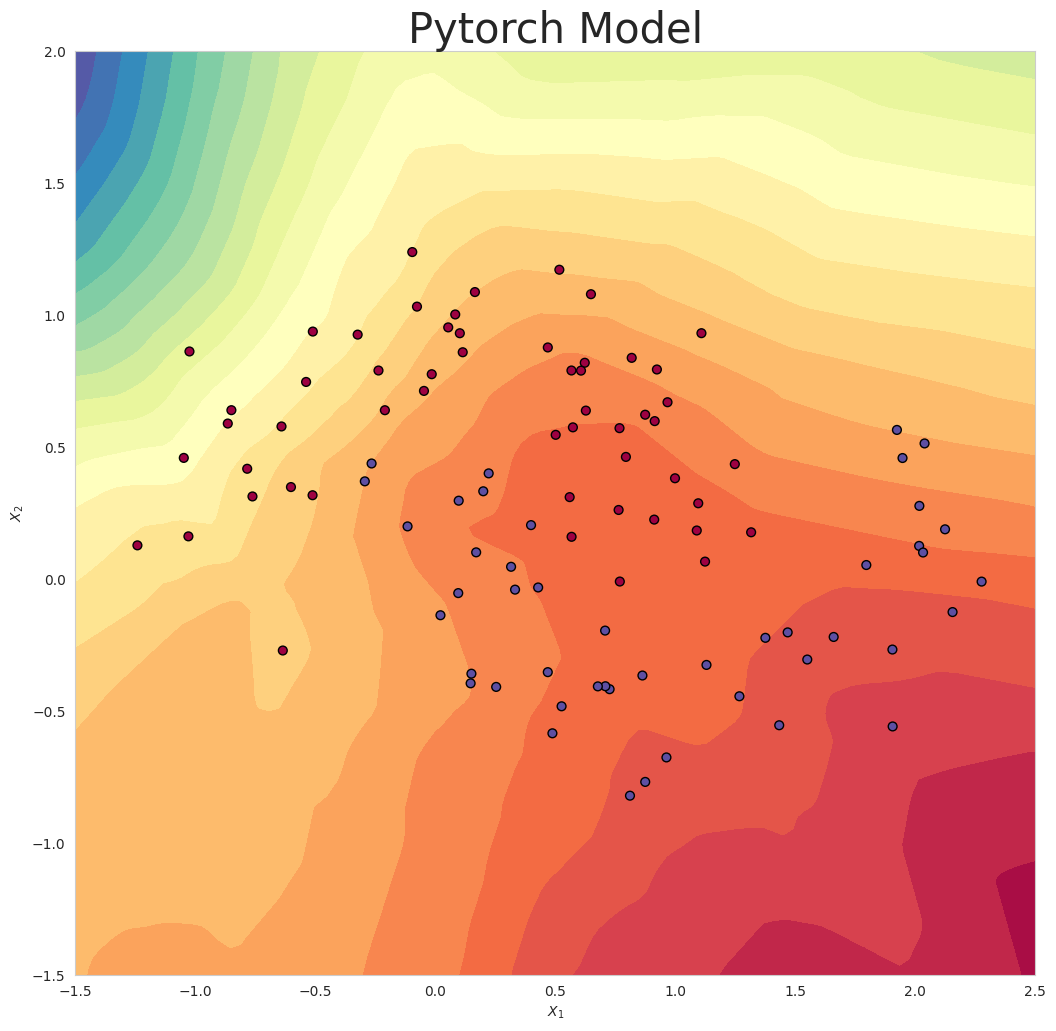

In [13]:
# D: Visualisierung der initialen Gewichte und dem Test set
# ---------
# E: Visualization of the initial weights and the test set
xx = torch.from_numpy(grid_2d).to(device,torch.float32)
y_plot = y_hat = model_init(xx).cpu().detach().numpy()
make_plot(X_test, y_test, "Pytorch Model", file_name=None, XX=XX, YY=YY, preds=y_plot)